<a href="https://colab.research.google.com/github/AurelioGuilherme/DNC_projetos/blob/main/Machine%20Learning/Regression_and_Clustering_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO DE CLUSTERIZAÇÃO E REGRESSÃO


## 1 - Importação de bibliotecas | Import libraries

In [44]:
# Data wrangling e data cleaning
import os
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling
from kmodes.kprototypes import KPrototypes
#from utils.plot_utils import valuesPlot

In [45]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='pastel',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

In [46]:
def valuesPlot(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Verifica se a altura é maior que 0
            ax.annotate(f'{int(height)}',  # Mostra o valor como um número inteiro
                        (p.get_x() + p.get_width() / 2, height),  # Posição do texto
                        ha='center',  # Alinhamento horizontal
                        va='center',  # Alinhamento vertical
                        xytext=(0, 6),  # Deslocamento do texto
                        textcoords='offset points')


In [47]:
def outlier(df):
  ''' A função retornara os valores considerados outliers inferiores e superiores
    x = valor que deseja descobrir
    quartil_75 = retorna o quartil 75%
    quartil_25 = retorna o quartil 25%
    outlier é a diferença de 1,5 vezes a diferença do amplitude
    interquantil
    C = constante
      ''' 
  quartil_75 = np.quantile(df,0.75)
  quartil_25 = np.quantile(df,0.25)
  c = 1.5
  intervalo_Interquartil =  quartil_75 - quartil_25
  outlier_Sup = quartil_75 + (c * intervalo_Interquartil)
  outlier_Inf = quartil_25 - (c * intervalo_Interquartil)
  return outlier_Inf,outlier_Sup

## 2 - Contextualização


**Objetivo:** O projeto tem como propósito a criação de uma solução de Data Science para a empresa Acerola Segurity.SA (empresa fictícia) que atua no ramo de seguros. A empresa procurou-me pois quer entender, estudar e se possível melhorar seus preços dos seguros.

Também foi solicitado a análise da influência do sexo no custo do seguro, pois a empresa pretende incluir uma campanha direcionada ao público feminino e assim promover mais diversidade e acesso a este público

Inicialmente implementaremos um modelo não supervisionado de Clusterização para criar grupos e avaliar melhor os clientes, trazendo insights para o time de inovação da empresa.

Também implementaremos um modelo supervisionado de Machine Learning para prever os valores de seguro.

### Features iniciais | RAWDATA features

O conjunto de dados possui 1341 linhas e 7 colunas:

* idade: idade do cliente (min:18 / max: 64)
* Sexo: Variável categórica correspondente ao genero do cliente (Homem / mulher)
* imc: Índice de Massa Corpórea
* quantidade_filhos: Quantidade de filhos (min: 0 / max: 5)
* fumante: Variável categórica corresponde se o cliente é fumante (yes / no)
* regiao: Variável categorica correspondente a localidade onde o cliete reside.
* custos_seguro: Corresponde o custo do seguro do cliente

In [48]:
file_path = os.path.join("../Data", "insurance.xlsx")
df = pd.read_excel(file_path)
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3 - Data cleaning

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


Alteração da tipagem dos dados para categorico das colunas idade, sexo, quantidade_filhos, fumante e região

In [50]:
colunas_categoricas = ["idade","sexo", "quantidade_filhos", "fumante", "regiao"]
df[colunas_categoricas] = df[colunas_categoricas].astype("category")

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   idade              1341 non-null   category
 1   sexo               1338 non-null   category
 2   imc                1341 non-null   float64 
 3   quantidade_filhos  1341 non-null   category
 4   fumante            1341 non-null   category
 5   regiao             1341 non-null   category
 6   custos_seguro      1341 non-null   float64 
dtypes: category(5), float64(2)
memory usage: 29.7 KB


### Identificando e removendo valores nulos.

Existem 3 valores nulos na coluna sexo.

In [52]:
df.isna().sum()

idade                0
sexo                 3
imc                  0
quantidade_filhos    0
fumante              0
regiao               0
custos_seguro        0
dtype: int64

Utilizando o metodo **query** indentificou-se os valores nulos, percebe-se que são valores idênticos e com custos de seguro igual a 0, portanto decidi por remove-los do conjunto de dados devido a serem valores incorretos que ocasionariam problemas com o modelo de regressão.

In [53]:
df.query('sexo != "male" & sexo !="female"')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
1259,30,NaN,40.09,0,no,northeast,0.0
1285,30,NaN,40.09,0,no,northeast,0.0
1331,30,NaN,40.09,0,no,northeast,0.0


In [54]:
df.query('custos_seguro == 0')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
1259,30,NaN,40.09,0,no,northeast,0.0
1285,30,NaN,40.09,0,no,northeast,0.0
1331,30,NaN,40.09,0,no,northeast,0.0


In [55]:
df = df.dropna().reset_index(drop=True)

### Identificando e removendo valores duplicados.

Existe somente um valor duplicado, porem para evitar problemas na etapa de modeling decidi por remove-lo previamente.

In [56]:
df[df.duplicated(keep = False)]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [57]:
df = df.drop_duplicates().reset_index(drop=True)

### Outliers

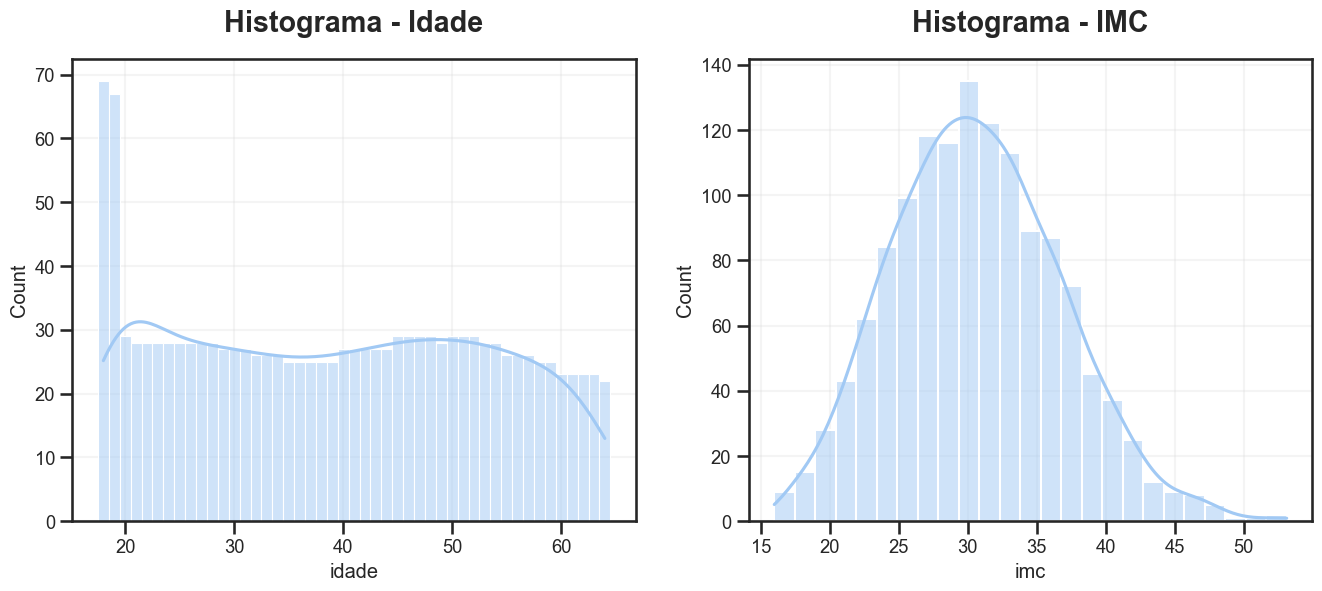

In [58]:
fig, axes = plt.subplots(1,2, figsize = (16,6))

axes[0] = sns.histplot(df.idade, kde=True, ax=axes[0])\
        .set_title('Histograma - Idade')

axes[1] = sns.histplot(df.imc, kde = True, ax=axes[1])\
             .set_title('Histograma - IMC')

- A variável idade apresenta dados dentro da normalidade, porém seguem uma distribuição uniforme.
- Ao analisar o histograma do IMC, observa-se que os dados seguem uma distribuição normal de probabilidade.

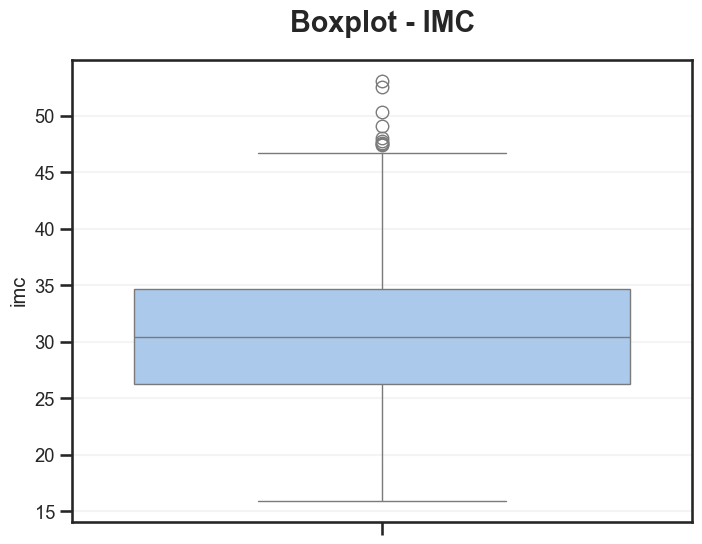

In [88]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(data = df.imc).set_title('Boxplot - IMC')

Para identificar os valores outliers, foi definida a função outlier, que recebe um objeto `pandas.Series` (no caso, a coluna em que os outliers serão identificados). A função retorna, assim, os valores outliers inferiores e superiores.

Utilizando o método **`pandas.query`** filtramos o dataframe mostrando somente os valores outliers 

In [60]:
outlier_inf, outlier_sup = outlier(df.imc)
df.query('imc >= @outlier_sup | imc <= @outlier_inf')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
846,23,male,50.38,1,no,southeast,2438.05520
859,37,female,47.60,2,yes,southwest,46113.51100
1046,22,male,52.58,1,yes,southeast,44501.39820
1087,52,male,47.74,1,no,southeast,9748.91060
1316,18,male,53.13,0,no,southeast,1163.46270


Foi identificado um total de 9 valores outliers no IMC. No entanto, após análise, concluiu-se que esses valores estão dentro do padrão esperado para o IMC, portanto, não será realizada a remoção dos mesmos.

- Custos do seguro

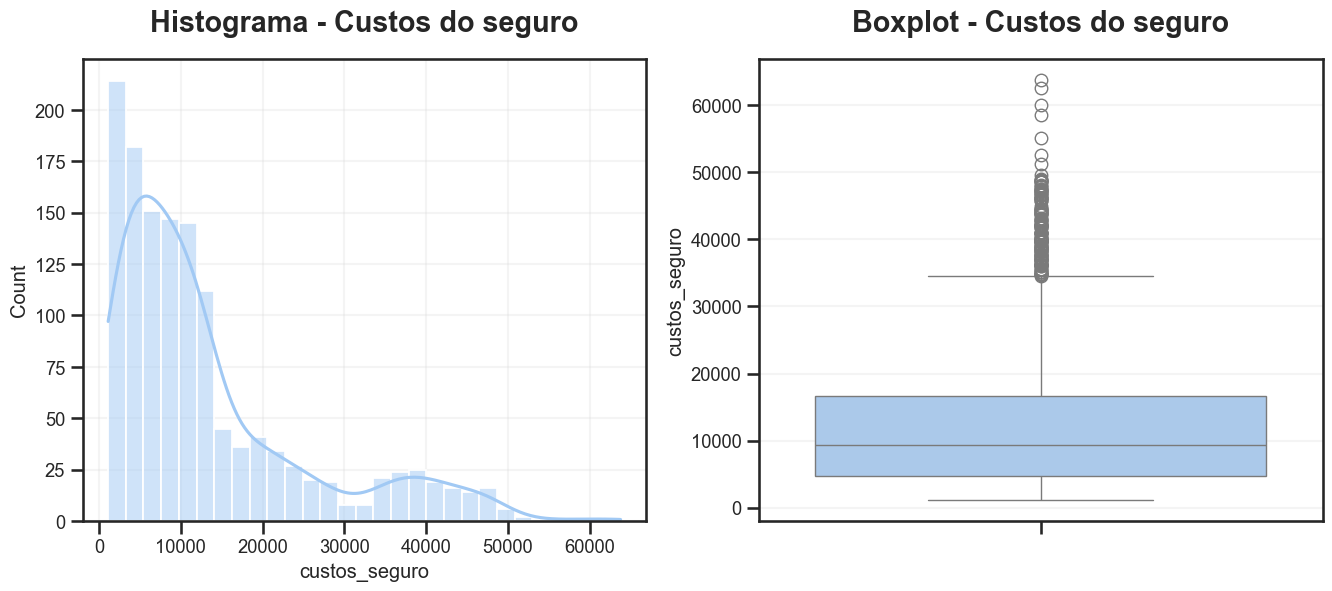

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0] = sns.histplot(df.custos_seguro, kde = True, ax=axes[0])\
          .set_title('Histograma - Custos do seguro')

axes[1] = sns.boxplot(data = df.custos_seguro, ax = axes[1])\
          .set_title('Boxplot - Custos do seguro')


In [62]:
outlier_inf, outlier_sup = outlier(df.custos_seguro)
df.query('custos_seguro >= @outlier_sup | custos_seguro <= @outlier_inf')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1299,45,male,30.360,0,yes,southeast,62592.87309
1300,62,male,30.875,3,yes,northwest,46718.16325
1302,43,male,27.800,0,yes,southwest,37829.72420
1312,19,female,34.700,2,yes,southwest,36397.57600


In [63]:
outlierDf = df.query('custos_seguro >= @outlier_sup | custos_seguro <= @outlier_inf' )

Utlizando a função **outlier** identificamos 139 valores outliers, cerca de 10,39% de nosso conjunto de dados, portanto será nessecario avaliar melhor esse grupo de dados indentificado como outliers

In [64]:
df.drop(outlierDf.index)

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


## 4 - EDA

In [65]:
df.describe()

,imc,custos_seguro
count,1337.000000,1337.000000
mean,30.663871,13279.121487
std,6.100648,12110.359656
min,15.960000,1121.873900
25%,26.290000,4746.344000
50%,30.400000,9386.161300
75%,34.700000,16657.717450
max,53.130000,63770.428010


### Análise gráfica 

- Idade

In [66]:
# Contagem de idade
idade_counts = df['idade'].value_counts().sort_index()

# Criando o gráfico de barras
fig = px.bar(x=idade_counts.index, 
             y=idade_counts.values, 
             labels={'x': 'Idade', 'y': 'Quantidade de Clientes'},
             title='Quantidade de clientes por idade', 
             template='plotly')


# Exibindo o gráfico
fig.show()

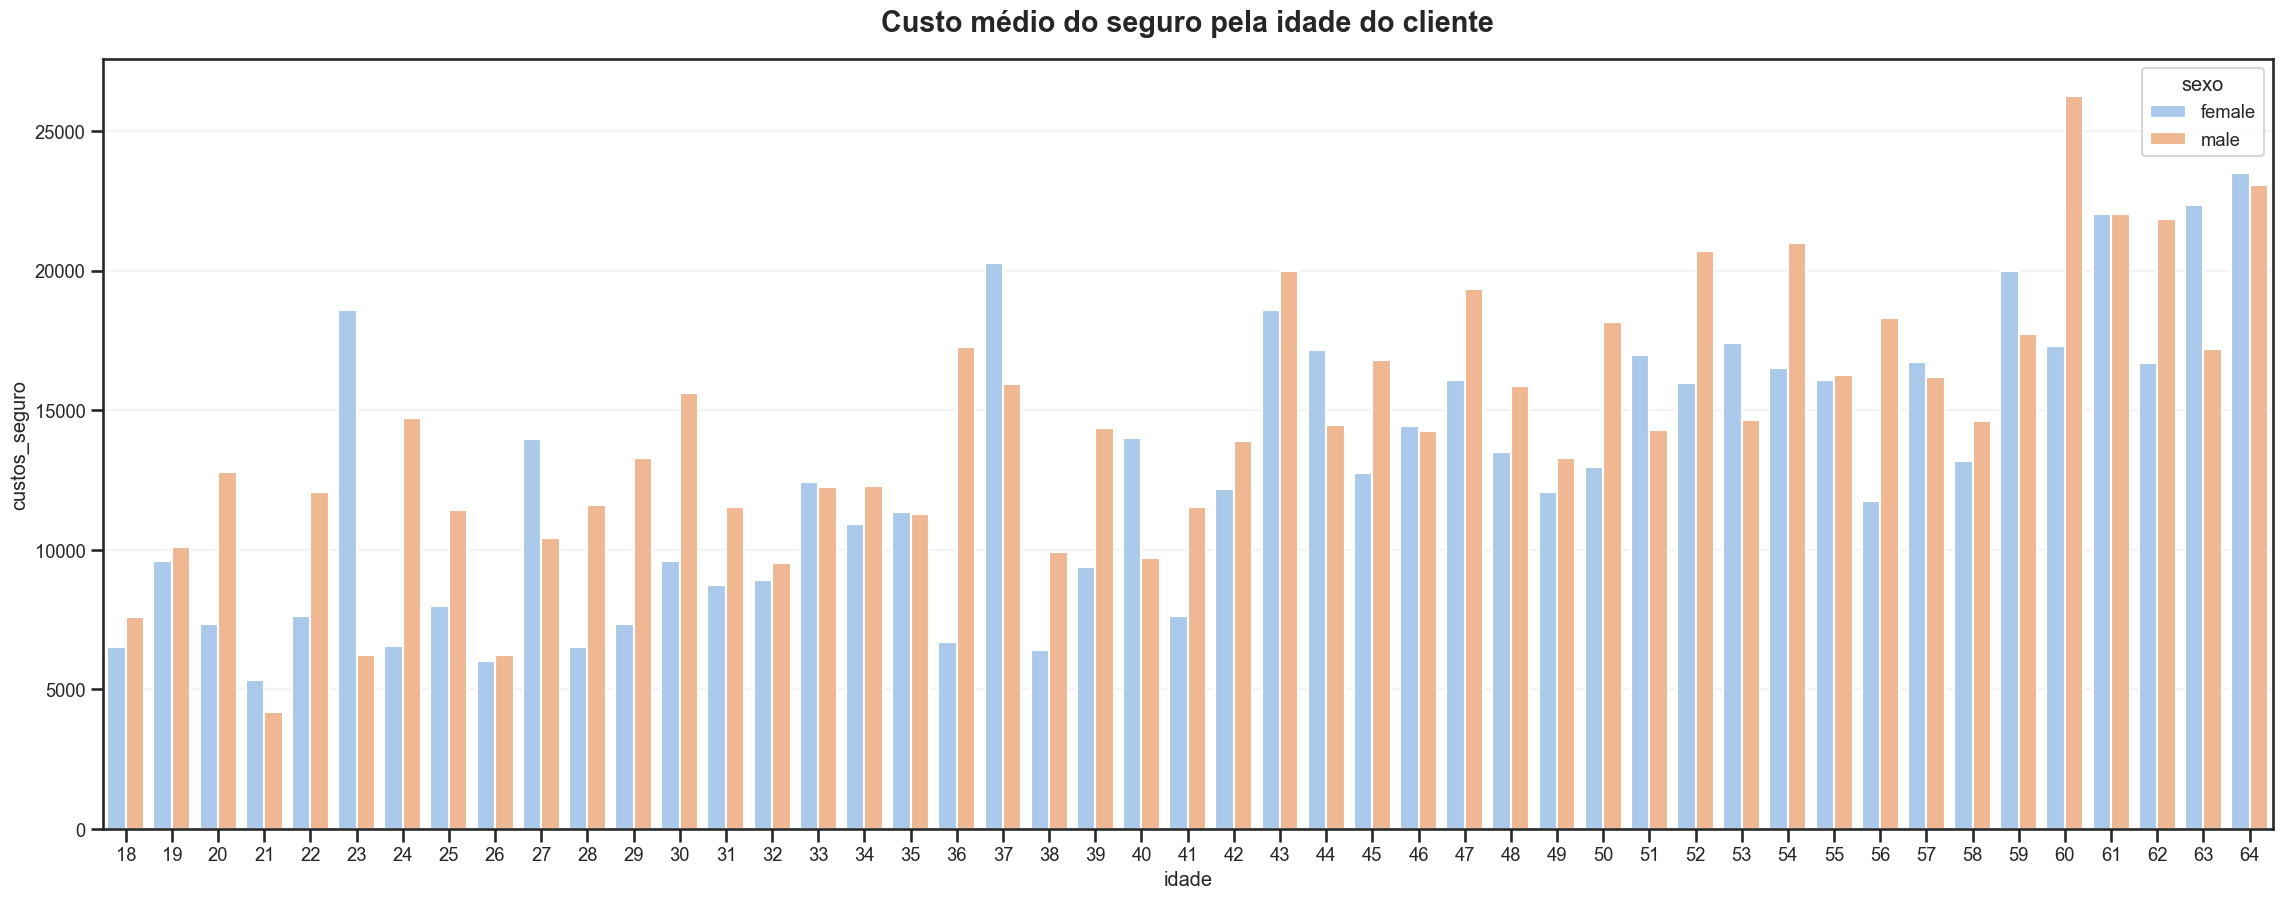

In [67]:
prov = df.groupby(['idade','sexo'], observed=True)[['custos_seguro']]\
         .mean()\
         .round()\
         .reset_index()


plt.figure(figsize = (28,10))
plt.title('Custo médio do seguro pela idade do cliente')
ax = sns.barplot(data = prov, 
            x = 'idade', 
            y = 'custos_seguro',
            hue = 'sexo'
            );
del prov


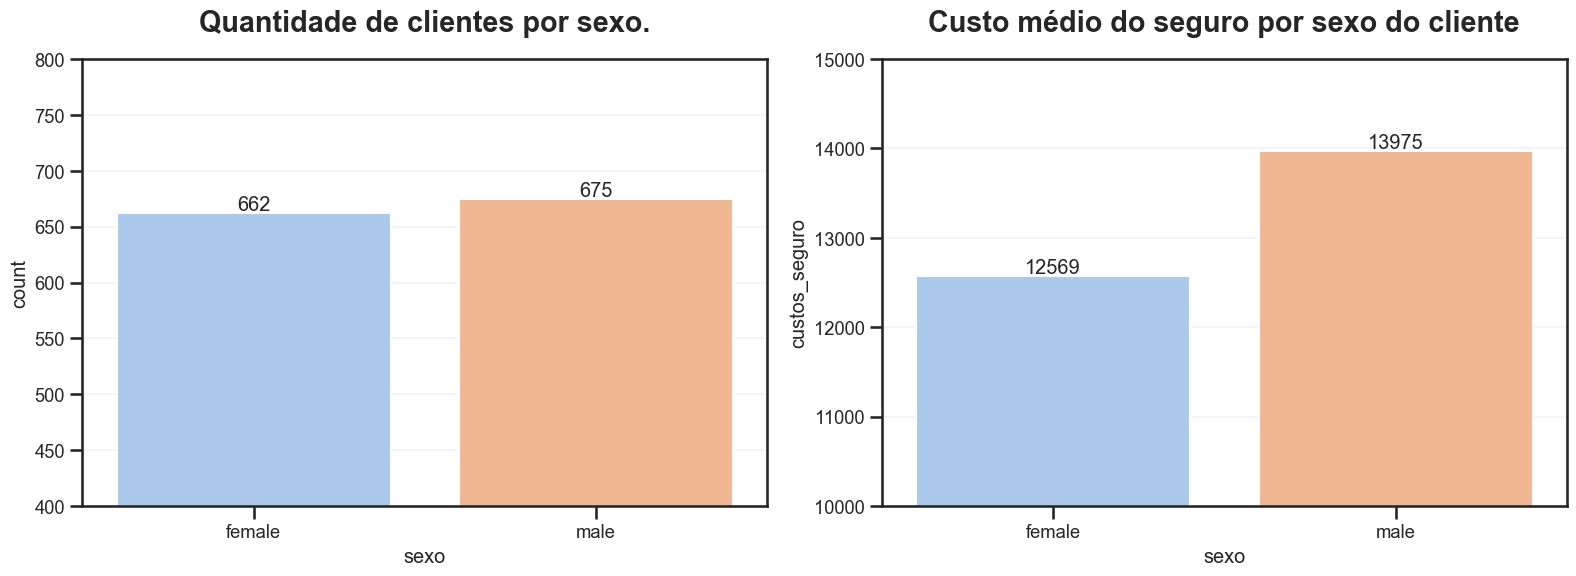

In [94]:
groupby_df = df.groupby('sexo', observed=False)[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0] = sns.countplot(data=df, x="sexo", hue="sexo", palette=("pastel"), ax=axes[0])
axes[0].set_title("Quantidade de clientes por sexo.")
axes[0].set_ylim(400,800)
valuesPlot(axes[0])

axes[1] = sns.barplot(data=groupby_df, x='sexo', y='custos_seguro', hue="sexo")
axes[1].set_title('Custo médio do seguro por sexo do cliente')
axes[1].set_ylim(10000, 15000)
valuesPlot(axes[1])
plt.tight_layout()
del groupby_df


- Fumante

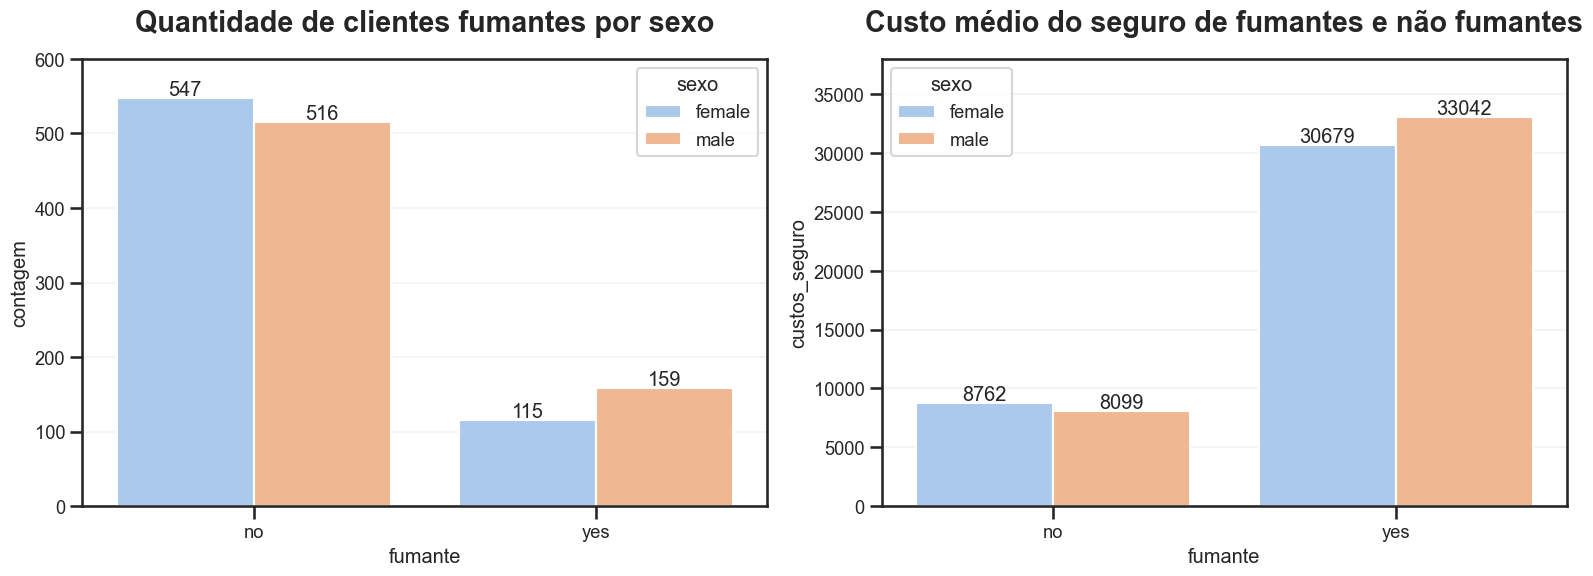

In [95]:
groupby_df_count = df.groupby(['fumante', 'sexo'], observed=True)[['fumante']].count()\
               .rename(columns = {'fumante': 'contagem'}).reset_index()

groupby_df_mean = df.groupby(['fumante','sexo'], observed=True)[['custos_seguro']].mean()\
              .round(2).reset_index()
  
fig, axes = plt.subplots(1,2, figsize = (16,6))

axes[0] = sns.barplot(data=groupby_df_count, x='fumante',y='contagem', hue='sexo', palette=("pastel"), ax=axes[0])
axes[0].set_title('Quantidade de clientes fumantes por sexo')
axes[0].set_ylim(0, 600)
valuesPlot(axes[0])

axes[1] = sns.barplot(data=groupby_df_mean, x='fumante', y='custos_seguro', hue='sexo', ax=axes[1])
axes[1].set_title('Custo médio do seguro de fumantes e não fumantes')
axes[1].set_ylim(0, 38000)
valuesPlot(axes[1])
plt.tight_layout()
plt.show()

del groupby_df_count, groupby_df_mean

- Filhos

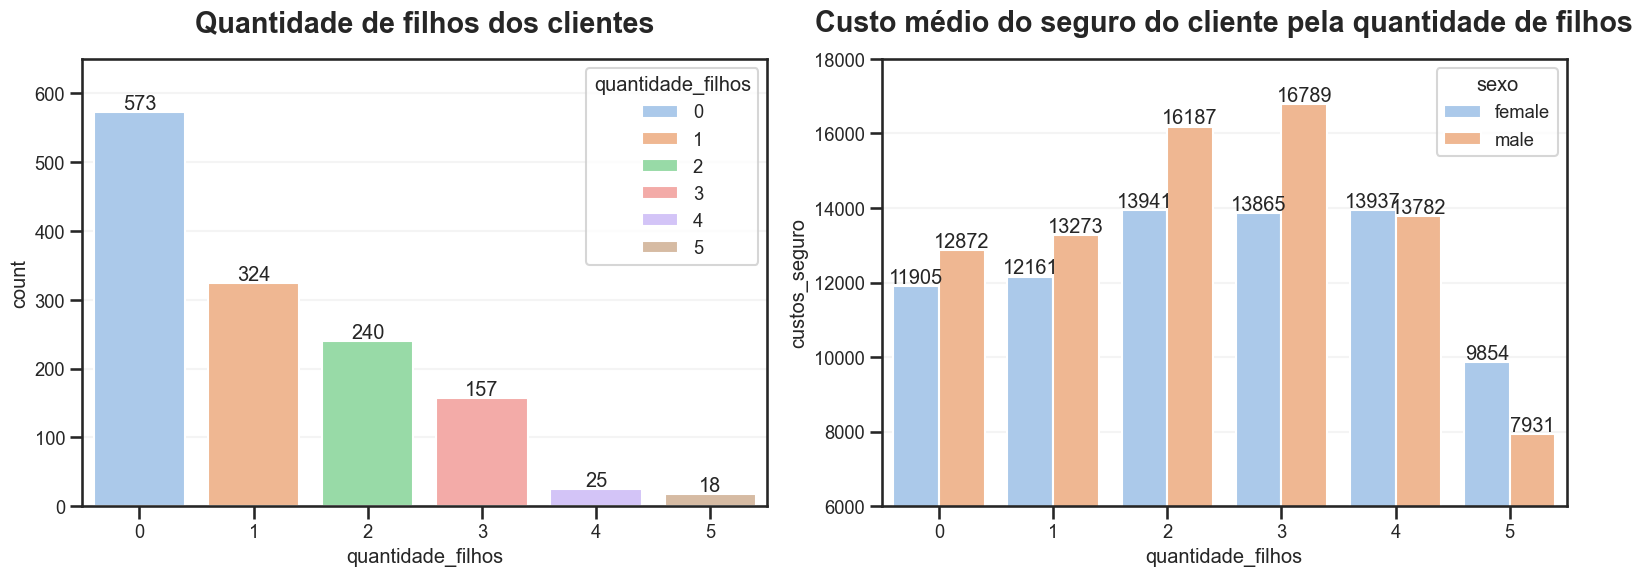

In [97]:
groupby_df = df.groupby(['quantidade_filhos', 'sexo'], observed=True)[['custos_seguro']].mean()\
               .round(2).reset_index()

fig, axes = plt.subplots(1, 2,  figsize = (16,6))

axes[0] = sns.countplot(data=df, x="quantidade_filhos", hue="quantidade_filhos", palette=("pastel"), ax=axes[0])
axes[0].set_title('Quantidade de filhos dos clientes')
axes[0].set_ylim(0, 650)
valuesPlot(axes[0])

axes[1] = sns.barplot(data=groupby_df, x='quantidade_filhos', y ='custos_seguro', hue='sexo', ax=axes[1])
axes[1].set_title('Custo médio do seguro do cliente pela quantidade de filhos')
axes[1].set_ylim(6000, 18000)      
valuesPlot(axes[1])

plt.tight_layout()
plt.show()
del groupby_df

- Região

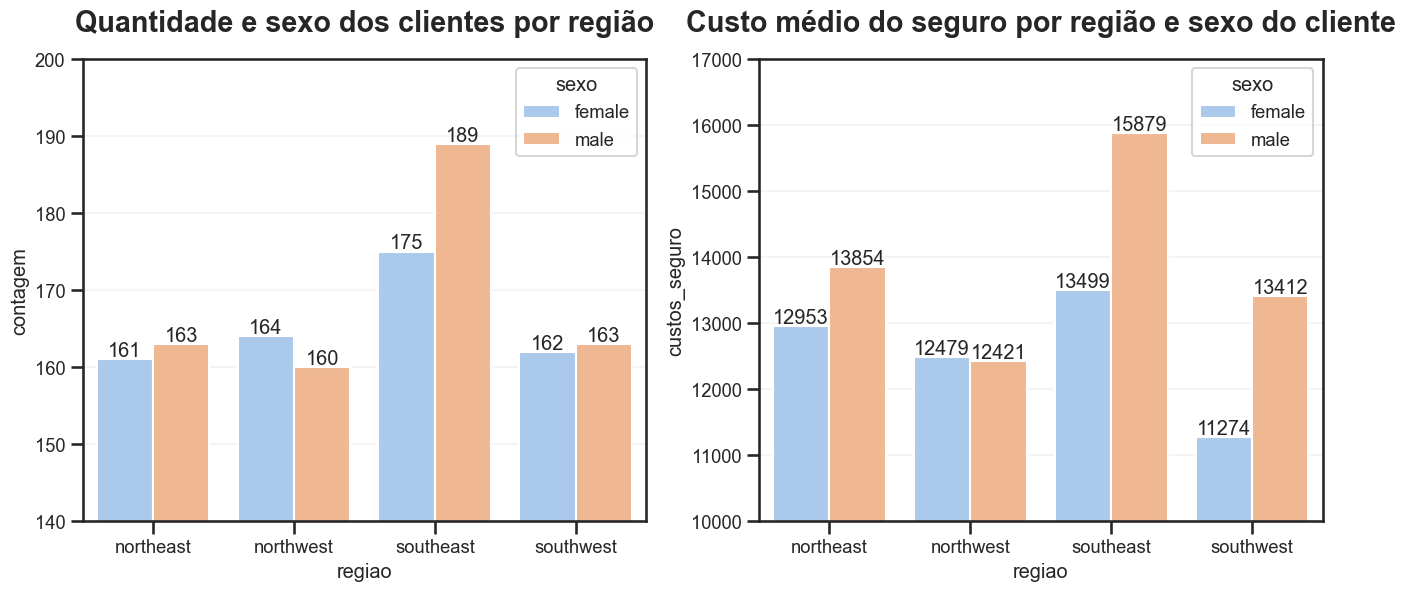

In [72]:
groupby_df_count = df.groupby(['regiao','sexo'], observed=True)[['sexo']].count()\
                     .rename(columns = {'sexo': 'contagem'}).reset_index()

groupby_df_mean = df.groupby(['regiao','sexo'], observed=True)[['custos_seguro']].mean().round(2).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0] = sns.barplot(data=groupby_df_count, x='regiao', y='contagem', hue='sexo', palette=("pastel"), ax=axes[0])
axes[0].set_title('Quantidade e sexo dos clientes por região')
axes[0].set_ylim(140, 200)
valuesPlot(axes[0])

axes[1] = sns.barplot(data=groupby_df_mean, x='regiao',y='custos_seguro', hue='sexo', ax=axes[1])
axes[1].set_title("Custo médio do seguro por região e sexo do cliente")
axes[1].set_ylim(10000, 17000)
valuesPlot(axes[1])

del groupby_df_count, groupby_df_mean


- IMC

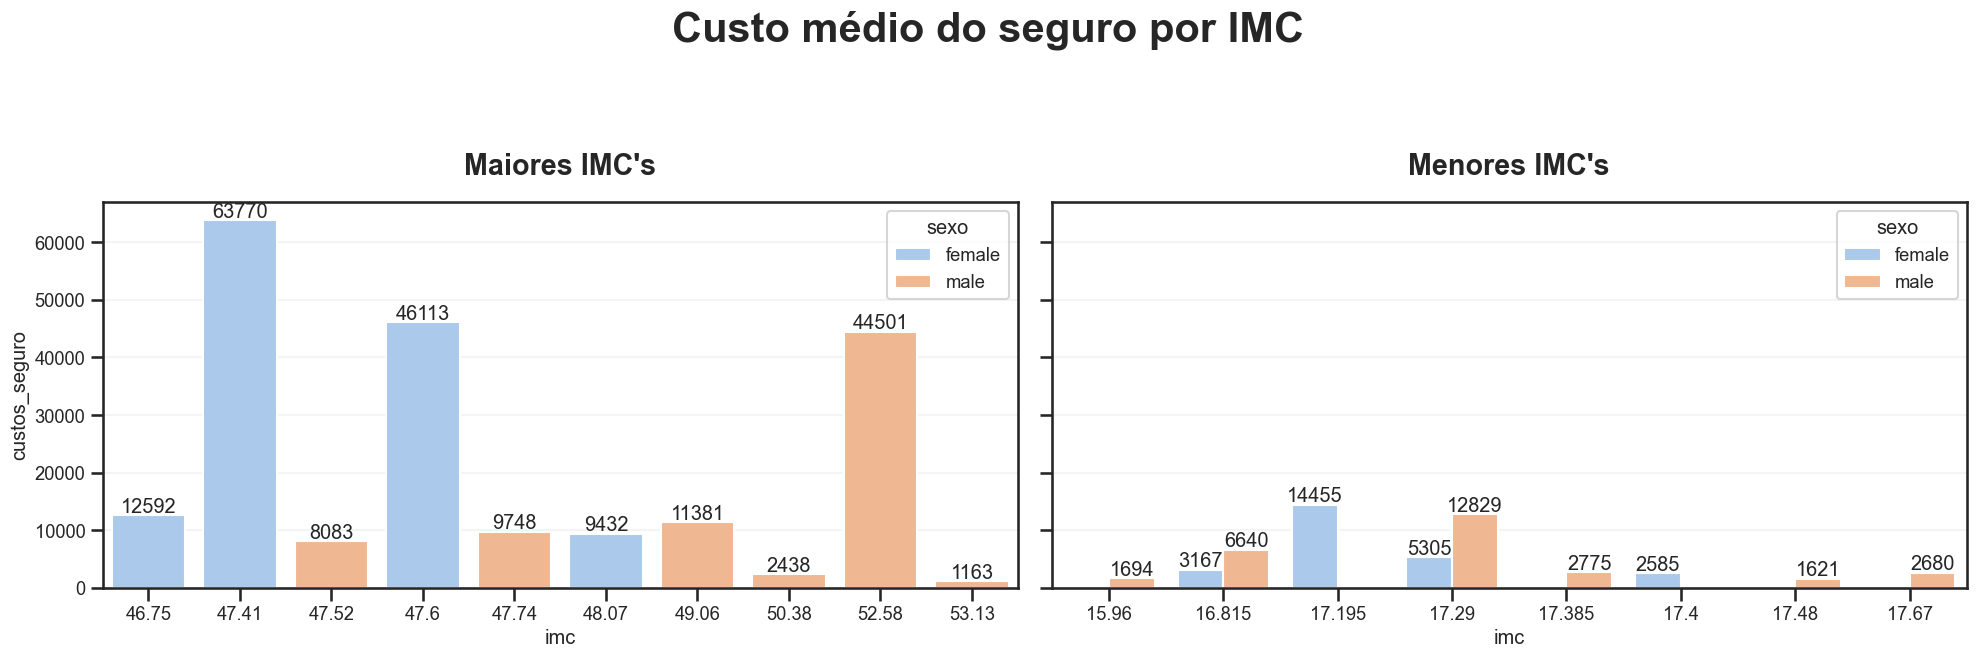

In [98]:
groupby_df = df.groupby(['imc','sexo'], observed=True)[['custos_seguro']].mean()\
               .reset_index().sort_values(by = 'imc', ascending = False)         
      
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig.suptitle('Custo médio do seguro por IMC', fontsize = 30, fontweight='bold').set_y(1.10)       

# Plot 1
plot = sns.barplot(ax=axes[0], data=groupby_df.head(10), x='imc', y='custos_seguro', hue='sexo')
axes[0].set_title("Maiores IMC's")
valuesPlot(axes[0])

#Plot 2
plot2 = sns.barplot(ax=axes[1], data=groupby_df.tail(10), x='imc',y='custos_seguro', hue='sexo')
axes[1].set_title("Menores IMC's")
valuesPlot(axes[1])

plt.tight_layout()
plt.show()

In [74]:
df['faixa_etaria'] = df['idade'].apply(lambda x : 'jovem' if x < 25 else 
                                                  'adulto' if x <= 59 else
                                                  'idoso' if x > 59 else x)\
                                                  .astype('category')
                             

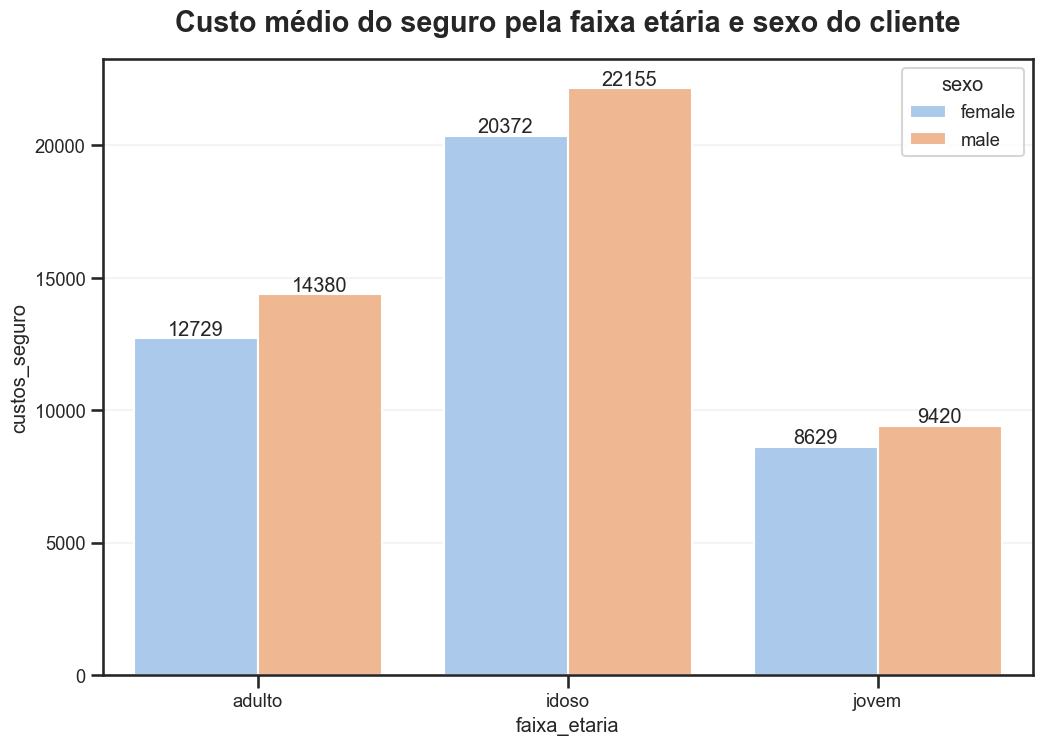

In [75]:
groupby_df = df.groupby(['faixa_etaria','sexo'], observed=True)[['custos_seguro']].mean().round(2).reset_index()
         
plt.figure(figsize=(12, 8))
plt.title("Custo médio do seguro pela faixa etária e sexo do cliente")
ax = sns.barplot(data=groupby_df, x='faixa_etaria', y='custos_seguro', hue='sexo')
valuesPlot(ax)
plt.show()

In [76]:
df['classe_IMC'] = df['imc'].apply(lambda x : 'Desnutrido' if x < 18.5 else 
                                                  'normal' if x < 25 else 
                                                 'sobpeso' if x < 30 else
                                             'obesidade_I' if x < 35 else 
                                            'obesidade_II' if x < 40 else
                                            'obsidade_III' if x >= 40 else x)\
                                            .astype('category')

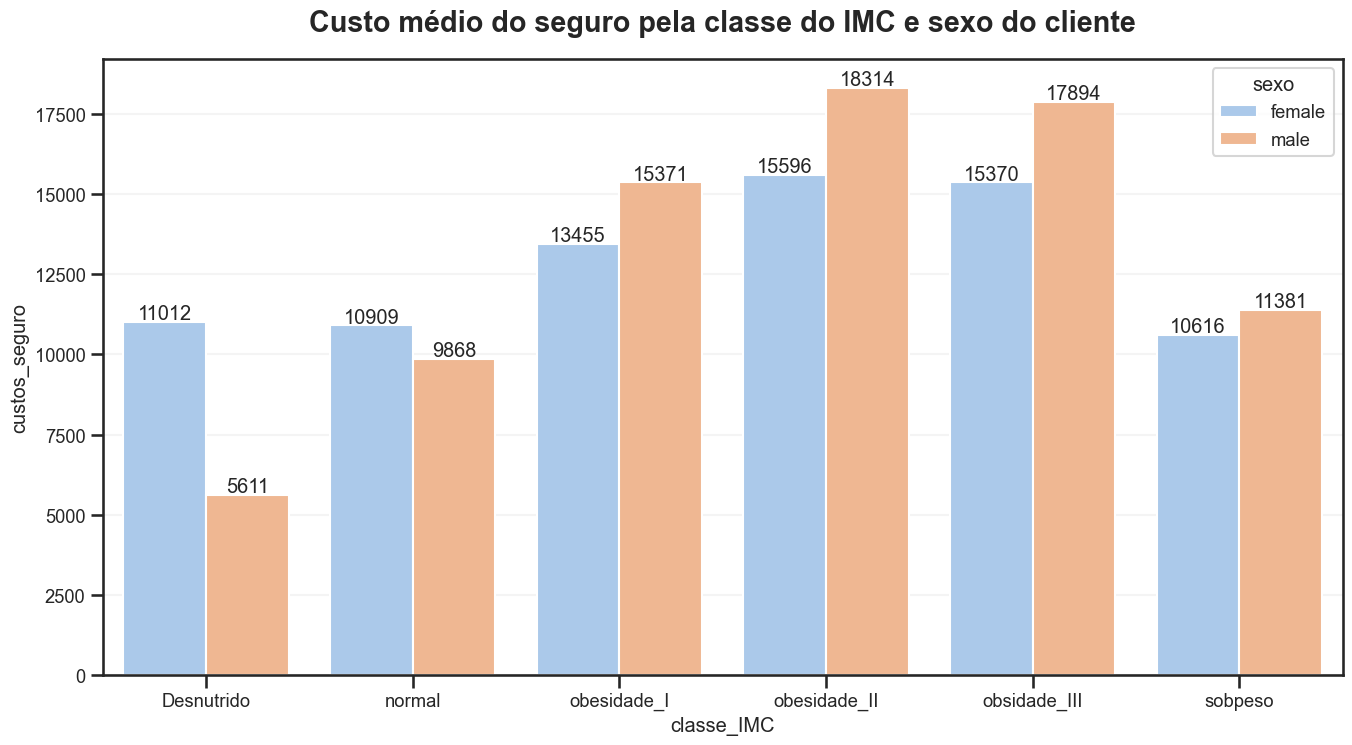

In [99]:
groupby_df = df.groupby(['classe_IMC','sexo'], observed=True)[['custos_seguro']].mean()\
               .round(2).reset_index()
         
plt.figure(figsize = (16,8))
plt.title("Custo médio do seguro pela classe do IMC e sexo do cliente")
plot = sns.barplot(data=groupby_df, x='classe_IMC', y='custos_seguro', hue='sexo')
valuesPlot(plot)
plt.show()

## 5 Cluster

In [113]:
df_cluster = df.drop(["idade", "imc"], axis=1).copy()

In [118]:
categorical_columns = ["sexo", "quantidade_filhos","fumante", "regiao", "faixa_etaria", "classe_IMC"]
for col in categorical_columns:
   df_cluster[col] = pd.Categorical(df_cluster[col]).codes.astype('object')

In [119]:
categorical_columns_indices = [df_cluster.columns.get_loc(col) for col in categorical_columns]


In [121]:
kproto = KPrototypes(n_clusters= 3, 
                     init='Cao', 
                     n_jobs = -1)
clusters = kproto.fit_predict(df_cluster, categorical=categorical_columns_indices)

In [122]:
df_cluster['cluster'] = clusters

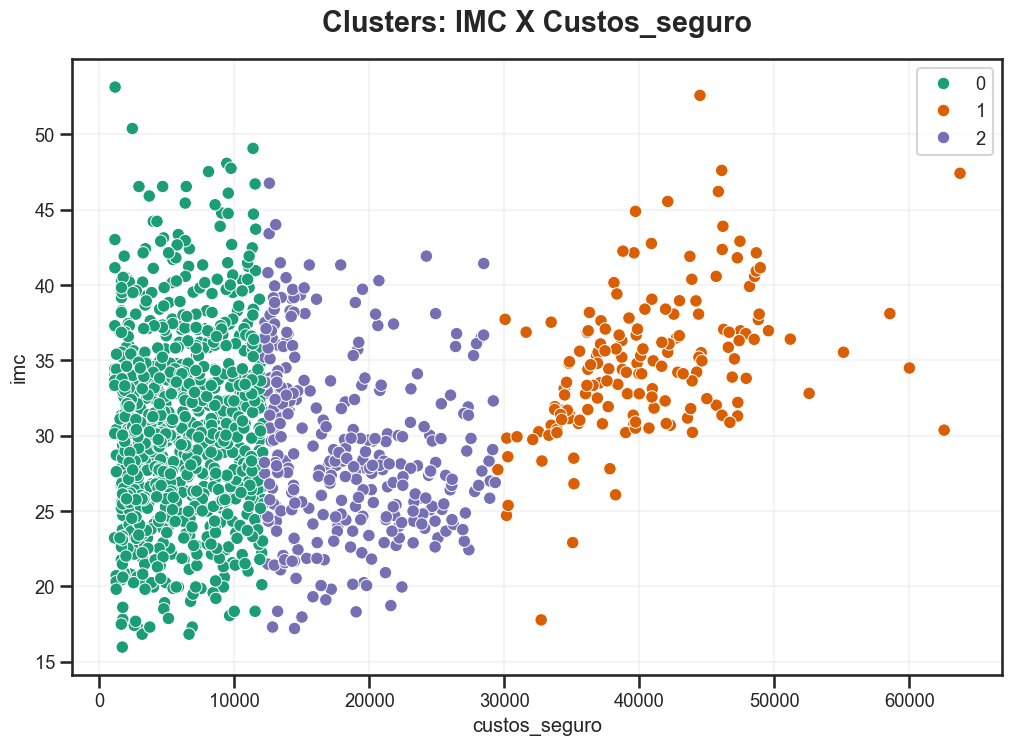

In [130]:
plt.title('Clusters: IMC X Custos_seguro')
ax = sns.scatterplot(data=df, x='custos_seguro', y='imc', hue=clusters, palette='Dark2')

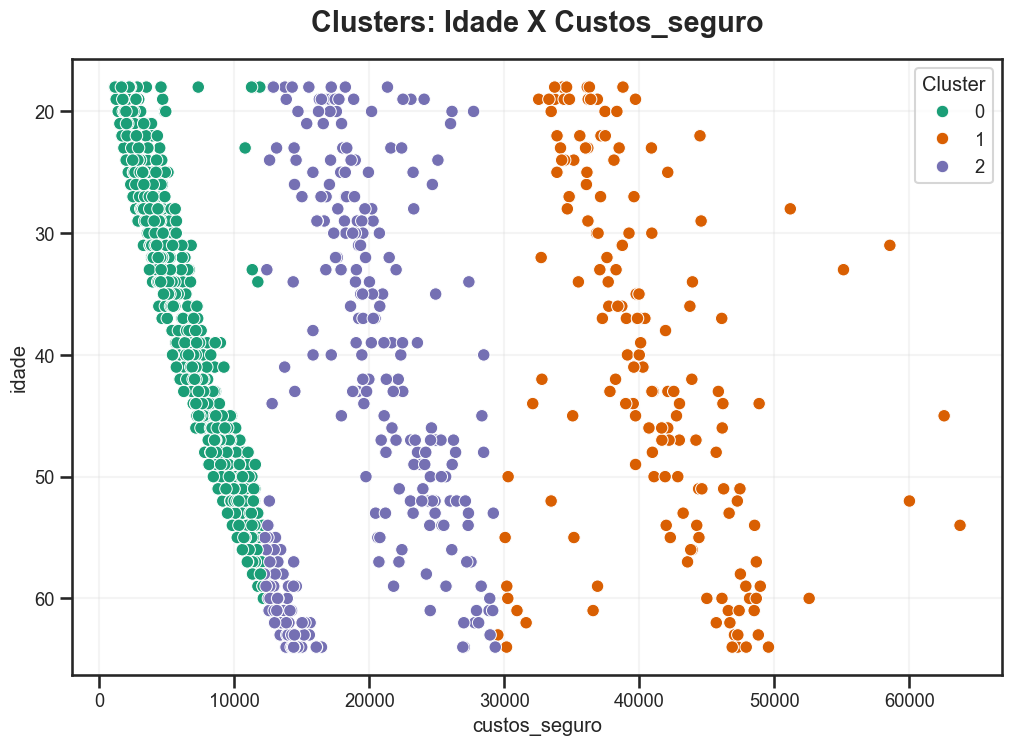

In [136]:
plt.title('Clusters: Idade X Custos_seguro')
ax = sns.scatterplot(data=df, x='custos_seguro', y='idade', hue=clusters, palette='Dark2')
plt.legend(title='Cluster')
plt.savefig("clusterizacao_seguros.png", dpi=300, bbox_inches='tight')